In [15]:
# for cliff walking game

import gym 
import torch
import torch.nn as nn
import torch.nn.functional as F

env = gym.make('CliffWalking-v0')


In [16]:
class ActorCriticModel(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super(ActorCriticModel,self).__init__()
        self.fc1 = nn.Linear(n_input, n_hidden[0])
        self.fc2 = nn.Linear(n_hidden[0],n_hidden[1])
        self.action = nn.Linear(n_hidden[1],n_output)
        self.value = nn.Linear(n_hidden[1],1)

    def forward(self, x ):
        x = torch.tensor(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        action_probs = F.softmax(self.action(x),dim = -1 )
        state_values = self.value(x)
        return action_probs, state_values
    


In [17]:
class PolicyNetwork():
    def __init__(self, n_state, n_action,n_hidden =50, lr = 0.001):
        self.model = ActorCriticModel(
            n_state, n_action, n_hidden
        )
        self.optimizer = torch.optim.Adam(self.model.parameters(),lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(
            self.optimizer,
            step_size = 10 ,
            gamma = 0.9 
        )

    def predict(self, s):
        
        return self.model(torch.Tensor(s))
    
    def update(self,returns,  log_probs, state_values):
        loss = 0 
        for log_prob, value, Gt in zip (log_probs,state_values, returns):
            advantage = Gt - value.item()
            policy_loss = -log_prob * advantage
            value_loss = F.smooth_l1_loss(value,Gt)
            loss += policy_loss  + value_loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def get_action(self, s):
        action_probs, state_value = self.predict(s)
        action = torch.multinomial(action_probs,1 ).item()
        log_prob = torch.log(action_probs[action])
        return action, log_prob, state_value
    
    

In [18]:
def actor_critic(env, estimator, n_episode, gamma =1.0):
    for episode in range(n_episode):
        log_probs = []
        rewards = []
        state_values =[]
        state,_ = env.reset()
        is_done = False
        while True:
            one_hot_state = [0]*48
            one_hot_state[state] = 1
            action, log_prob, state_value = estimator.get_action(one_hot_state)
            next_state , reward, terminated, truncated ,_= env.step(action)
            if terminated or truncated:
                is_done = True

            total_reward_episode[episode] += reward
            log_probs.append(log_prob)
            state_values.append(state_value)
            rewards.append(reward)

            if is_done:
                returns = []
                Gt = 0
                pw = 0
                for reward in rewards[::-1]:
                    Gt += gamma ** pw *reward
                    pw += 1
                    returns.append(Gt)
                returns = returns[::-1]
                returns = torch.Tensor(returns)            
                returns = (returns - returns.mean())/(returns.std() + 1e-9)

                estimator.update(
                    returns, log_probs, state_values
                )
                print('Episode: {}, total reward: {}'.format(episode, total_reward_episode[episode]))

                if total_reward_episode[episode] >= -14:
                    estimator.scheduler.step()
                break

            state = next_state
            

In [19]:
n_state = 48 
n_action = env.action_space.n
n_hidden = [128, 32]
lr = 0.03
policy_net = PolicyNetwork(n_state, n_action, n_hidden, lr)

gamma = 0.9

In [20]:
n_episode = 1000
total_reward_episode = [0] * n_episode 
actor_critic(env, policy_net, n_episode, gamma)
  

/tmp/ipykernel_26718/291995499.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)
/tmp/ipykernel_26718/1557482155.py:22: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.smooth_l1_loss(value,Gt)


Episode: 0, total reward: -38254
Episode: 1, total reward: -11114
Episode: 2, total reward: -10911
Episode: 3, total reward: -33418
Episode: 4, total reward: -1816
Episode: 5, total reward: -3221
Episode: 6, total reward: -4375
Episode: 7, total reward: -8982
Episode: 8, total reward: -4154
Episode: 9, total reward: -229
Episode: 10, total reward: -3072
Episode: 11, total reward: -726
Episode: 12, total reward: -36
Episode: 13, total reward: -1365
Episode: 14, total reward: -1539
Episode: 15, total reward: -2254
Episode: 16, total reward: -1048
Episode: 17, total reward: -3753
Episode: 18, total reward: -529
Episode: 19, total reward: -955
Episode: 20, total reward: -240
Episode: 21, total reward: -1129
Episode: 22, total reward: -2963
Episode: 23, total reward: -324
Episode: 24, total reward: -2130
Episode: 25, total reward: -2030
Episode: 26, total reward: -3400
Episode: 27, total reward: -332
Episode: 28, total reward: -1241
Episode: 29, total reward: -1059
Episode: 30, total reward

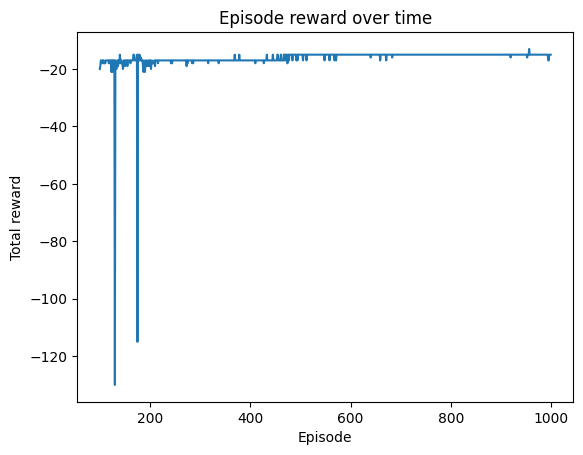

In [21]:
import matplotlib.pyplot as plt
plt.plot(range(100, n_episode), total_reward_episode[100:])
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()
